# Exercise 6-3

## LSTM

The following two cells will create a LSTM cell with one neuron.
We scale the output of the LSTM linear and add a bias.
Then the output will be wrapped by a sigmoid activation.
The goal is to predict a time series where every $n^{th}$ ($5^{th}$ in the current example) element is 1 and all others are 0.

a) Please read and understand the source code below.

b) Consult the output of the predictions. What do you observe? How does the LSTM manage to predict the next element in the sequence?

In [4]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt

In [7]:
tf.reset_default_graph()
tf.set_random_seed(12314)

epochs=50
zero_steps = 5
learning_rate = 0.01
lstm_neurons = 1
out_dim = 1

num_features = 1
batch_size = zero_steps
window_size = zero_steps*2
time_steps = 5

x = tf.placeholder(tf.float32, [None, window_size, num_features], 'x')
y = tf.placeholder(tf.float32, [None, out_dim], 'y')

lstm = tf.nn.rnn_cell.LSTMCell(lstm_neurons)
state = lstm.zero_state(batch_size, dtype=tf.float32)

regression_w = tf.Variable(tf.random_normal([lstm_neurons]))
regression_b = tf.Variable(tf.random_normal([out_dim]))

outputs, state = tf.contrib.rnn.static_rnn(lstm, tf.unstack(x, window_size, 1), state)
output = outputs[-1]
predicted = tf.nn.sigmoid(output * regression_w + regression_b)
cost = tf.reduce_mean(tf.losses.mean_squared_error(y, predicted))
optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate).minimize(cost)


forget_gate = output.op.inputs[1].op.inputs[0].op.inputs[0].op.inputs[0]
input_gate = output.op.inputs[1].op.inputs[0].op.inputs[1].op.inputs[0]
cell_candidates = output.op.inputs[1].op.inputs[0].op.inputs[1].op.inputs[1]
output_gate_sig = output.op.inputs[0]
output_gate_tanh = output.op.inputs[1]


X = [
        [[ (shift-n) % zero_steps == 0 ] for n in range(window_size)
    ] for shift in range(batch_size)
]
Y = [[ shift % zero_steps == 0 ] for shift in range(batch_size) ]


with tf.Session() as sess:
    sess.run(tf.initializers.global_variables())

    loss = 1
    epoch = 0
    while loss >= 1e-5:
        epoch += 1
        _, loss = sess.run([optimizer, cost], {x:X, y:Y})

        if epoch % (epochs//10) == 0:
            print("loss %.5f" % (loss), end='\t\t\r')
    print()
    
    outs, stat, pred, fg, inpg, cell_cands, outg_sig, outg_tanh = sess.run([outputs, state, predicted, forget_gate, input_gate, cell_candidates, output_gate_sig, output_gate_tanh], {x:X, y:Y})
    outs = np.asarray(outs)
    for batch in reversed(range(batch_size)):
        print("input:")
        print(np.asarray(X)[batch].astype(int).reshape(-1))
        print("forget\t\t%.4f\ninput gate\t%.4f\ncell cands\t%.4f\nout gate sig\t%.4f\nout gate tanh\t%.4f\nhidden state\t%.4f\ncell state\t%.4f\npred\t\t%.4f\n\n" % (
            fg[batch,0], 
            inpg[batch,0], 
            cell_cands[batch,0], 
            outg_sig[batch,0], 
            outg_tanh[batch,0], 
            stat.h[batch,0], 
            stat.c[batch,0], 
            pred[batch,0]))

loss 0.00001		
input:
[0 0 0 0 1 0 0 0 0 1]
forget		0.0135
input gate	0.9997
cell cands	0.9994
out gate sig	1.0000
out gate tanh	0.7586
hidden state	0.7586
cell state	0.9928
pred		0.0000


input:
[0 0 0 1 0 0 0 0 1 0]
forget		0.8747
input gate	0.9860
cell cands	-0.0476
out gate sig	1.0000
out gate tanh	0.6759
hidden state	0.6759
cell state	0.8215
pred		0.0000


input:
[0 0 1 0 0 0 0 1 0 0]
forget		0.8504
input gate	0.9877
cell cands	-0.1311
out gate sig	0.9999
out gate tanh	0.5148
hidden state	0.5147
cell state	0.5692
pred		0.0000


input:
[0 1 0 0 0 0 1 0 0 0]
forget		0.7921
input gate	0.9903
cell cands	-0.2875
out gate sig	0.9999
out gate tanh	0.1646
hidden state	0.1646
cell state	0.1661
pred		0.0052


input:
[1 0 0 0 0 1 0 0 0 0]
forget		0.6150
input gate	0.9943
cell cands	-0.5732
out gate sig	0.9997
out gate tanh	-0.4363
hidden state	-0.4361
cell state	-0.4676
pred		0.9953




LSTM gates:
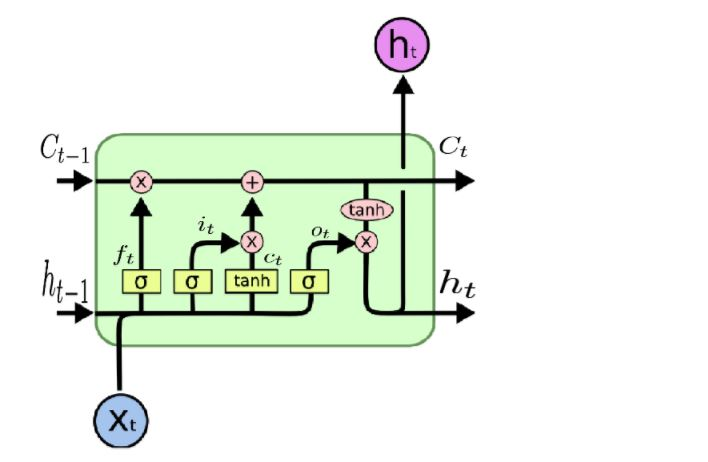

(image source: https://www.stratio.com/wp-content/uploads/2017/10/6-1.jpg)

### Answers

* When the current element is 1, then the forget-gate tells "forget" (value is close to 0) $\Rightarrow$ Reset cell state
* The cell state (long term memory) decreases until it reached some certain point. Then the hidden state is activated and thus the prediction is close to 1.
* The sigomoid output cell ($o_t$) is always close to 1 $\Rightarrow$ the hidden layer directly dependent on the cell state (no short term memory is used).
* The input gate ($i_t$) is always close to 1 thus the cell candidates ($c_t$) will always be accepted
* The cell candidates ($c_t$) are mainly dependent on $x_t$. It is close to 1 when $x_t$ is one (resetting the counter) and negative if $x_t$ is 0 (decreasing the counter).

Note that with other initial values (different seed) it may result in a different local minimum (the counter could increase, $h_t$ could be negative and be scaled negative, ...)